In [1]:
import xml.etree.ElementTree as ET
from datetime import datetime

def convert_routes(input_file, output_file):
    # Parse the input XML file
    tree = ET.parse(input_file)
    root = tree.getroot()

    # Create a new XML root for the output file
    new_root = ET.Element("routes", attrib=root.attrib)
    new_root.set("xmlns:xsi", "http://www.w3.org/2001/XMLSchema-instance")
    new_root.set("xsi:noNamespaceSchemaLocation", "http://sumo.dlr.de/xsd/routes_file.xsd")

    # Add a comment about the file generation
    comment = ET.Comment(
        f"Generated on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')} by Python Script"
    )
    new_root.append(comment)

    # Iterate over each vehicle in the original file
    for vehicle in root.findall("vehicle"):
        vehicle_id = vehicle.get("id")
        depart = vehicle.get("depart")
        route = vehicle.find("route").get("edges")

        # Create GNSS vehicle
        gnss_vehicle = ET.SubElement(new_root, "vehicle", {
            "id": f"{vehicle_id}gnss",
            "depart": depart,
            "color": "0,255,0,255"  # Green for GNSS
        })
        ET.SubElement(gnss_vehicle, "param", {
            "key": "posNoise",
            "value": "0.1"  # Low noise for GNSS
        })
        ET.SubElement(gnss_vehicle, "route", {
            "edges": route
        })

        # Create GPS vehicle
        gps_vehicle = ET.SubElement(new_root, "vehicle", {
            "id": f"{vehicle_id}gps",
            "depart": depart,
            "color": "255,0,0,255"  # Red for GPS
        })
        ET.SubElement(gps_vehicle, "param", {
            "key": "posNoise",
            "value": "5"  # High noise for GPS
        })
        ET.SubElement(gps_vehicle, "route", {
            "edges": route
        })

    # Write the new XML to the output file
    tree = ET.ElementTree(new_root)
    with open(output_file, "wb") as f:
        f.write(b'<?xml version="1.0" encoding="UTF-8"?>\n')
        tree.write(f, encoding="UTF-8", xml_declaration=False)
    print(f"Converted routes written to {output_file}")

# File paths
input_file = "campus(good).rou.xml"  # Replace with the path to your input file
output_file = "campusnew.rou.xml"  # Replace with the desired output file path

# Convert the routes
convert_routes(input_file, output_file)


Converted routes written to campusnew.rou.xml


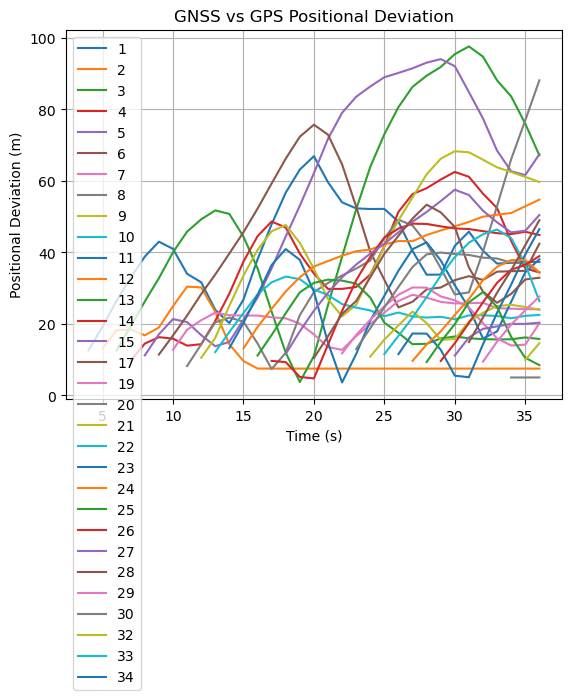

In [26]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np

def parse_fcd_output(fcd_file):
    vehicle_positions = {}
    tree = ET.parse(fcd_file)
    root = tree.getroot()

    for timestep in root.findall("timestep"):
        time = float(timestep.get("time"))
        for vehicle in timestep.findall("vehicle"):
            vehicle_id = vehicle.get("id")
            x, y = float(vehicle.get("x")), float(vehicle.get("y"))
            speed = float(vehicle.get("speed"))

            if vehicle_id not in vehicle_positions:
                vehicle_positions[vehicle_id] = {"time": [], "x": [], "y": [], "speed": []}
            
            vehicle_positions[vehicle_id]["time"].append(time)
            vehicle_positions[vehicle_id]["x"].append(x)
            vehicle_positions[vehicle_id]["y"].append(y)
            vehicle_positions[vehicle_id]["speed"].append(speed)
    
    return vehicle_positions

def calculate_positional_deviation(vehicle_positions):
    deviations = {}
    for vehicle_id in vehicle_positions:
        if "gnss" in vehicle_id:
            gps_id = vehicle_id.replace("gnss", "gps")
            if gps_id in vehicle_positions:
                gnss_data = vehicle_positions[vehicle_id]
                gps_data = vehicle_positions[gps_id]

                # Align times
                gnss_time = np.array(gnss_data["time"])
                gps_time = np.array(gps_data["time"])
                common_times = np.intersect1d(gnss_time, gps_time)

                if len(common_times) > 0:
                    # Interpolate positions to align times
                    x_gnss = np.interp(common_times, gnss_time, gnss_data["x"])
                    y_gnss = np.interp(common_times, gnss_time, gnss_data["y"])
                    x_gps = np.interp(common_times, gps_time, gps_data["x"])
                    y_gps = np.interp(common_times, gps_time, gps_data["y"])

                    # Calculate positional deviations
                    deviation = np.sqrt((x_gnss - x_gps)**2 + (y_gnss - y_gps)**2)
                    deviations[vehicle_id] = {"time": common_times, "deviation": deviation}
    return deviations

def plot_deviation(deviations):
    for vehicle_id, data in deviations.items():
        plt.plot(data["time"], data["deviation"], label=vehicle_id.replace("gnss", ""))
    plt.xlabel("Time (s)")
    plt.ylabel("Positional Deviation (m)")
    plt.title("GNSS vs GPS Positional Deviation")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_trajectories(vehicle_positions, vehicle_id_gnss, vehicle_id_gps):
    x_gnss = vehicle_positions[vehicle_id_gnss]["x"]
    y_gnss = vehicle_positions[vehicle_id_gnss]["y"]
    x_gps = vehicle_positions[vehicle_id_gps]["x"]
    y_gps = vehicle_positions[vehicle_id_gps]["y"]

    plt.plot(x_gnss, y_gnss, label="GNSS Trajectory", linestyle="--", color="green")
    plt.plot(x_gps, y_gps, label="GPS Trajectory", linestyle="-", color="red")
    plt.xlabel("X Position (m)")
    plt.ylabel("Y Position (m)")
    plt.title(f"Trajectory Comparison: {vehicle_id_gnss}")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example Usage
fcd_file = "fcd_output.xml"
vehicle_positions = parse_fcd_output(fcd_file)
deviations = calculate_positional_deviation(vehicle_positions)

# Plot Positional Deviations
plot_deviation(deviations)


In [19]:
import xml.etree.ElementTree as ET
import numpy as np

def parse_fcd_output(fcd_file):
    vehicle_positions = {}
    tree = ET.parse(fcd_file)
    root = tree.getroot()

    for timestep in root.findall("timestep"):
        time = float(timestep.get("time"))
        for vehicle in timestep.findall("vehicle"):
            vehicle_id = vehicle.get("id")
            x, y = float(vehicle.get("x")), float(vehicle.get("y"))
            
            if vehicle_id not in vehicle_positions:
                vehicle_positions[vehicle_id] = {"time": [], "x": [], "y": []}
            
            vehicle_positions[vehicle_id]["time"].append(time)
            vehicle_positions[vehicle_id]["x"].append(x)
            vehicle_positions[vehicle_id]["y"].append(y)
    
    return vehicle_positions

def calculate_total_deviation(vehicle_positions):
    deviations_summary = []
    for vehicle_id in vehicle_positions:
        if "gnss" in vehicle_id:
            gps_id = vehicle_id.replace("gnss", "gps")
            if gps_id in vehicle_positions:
                # Align times
                gnss_data = vehicle_positions[vehicle_id]
                gps_data = vehicle_positions[gps_id]
                gnss_time = np.array(gnss_data["time"])
                gps_time = np.array(gps_data["time"])
                common_times = np.intersect1d(gnss_time, gps_time)

                if len(common_times) > 0:
                    # Interpolate positions to align times
                    x_gnss = np.interp(common_times, gnss_time, gnss_data["x"])
                    y_gnss = np.interp(common_times, gnss_time, gnss_data["y"])
                    x_gps = np.interp(common_times, gps_time, gps_data["x"])
                    y_gps = np.interp(common_times, gps_time, gps_data["y"])

                    # Calculate total deviation
                    total_deviation = np.sum(np.sqrt((x_gnss - x_gps) ** 2 + (y_gnss - y_gps) ** 2))
                    deviations_summary.append((vehicle_id, gps_id, total_deviation))
    
    # Sort by total deviation in descending order
    deviations_summary.sort(key=lambda x: x[2], reverse=True)
    return deviations_summary

# Example Usage
fcd_file = "fcd_output.xml"
vehicle_positions = parse_fcd_output(fcd_file)
deviations_summary = calculate_total_deviation(vehicle_positions)

# Display top 5 vehicle pairs with the most deviation
print("Top Vehicles with Most Positional Deviation:")
for gnss_id, gps_id, total_dev in deviations_summary[:5]:
    print(f"GNSS: {gnss_id}, GPS: {gps_id}, Total Deviation: {total_dev:.2f}")


Top Vehicles with Most Positional Deviation:
GNSS: 3gnss, GPS: 3gps, Total Deviation: 1662.14
GNSS: 5gnss, GPS: 5gps, Total Deviation: 1652.10
GNSS: 1gnss, GPS: 1gps, Total Deviation: 1326.50
GNSS: 6gnss, GPS: 6gps, Total Deviation: 1141.52
GNSS: 9gnss, GPS: 9gps, Total Deviation: 1128.37


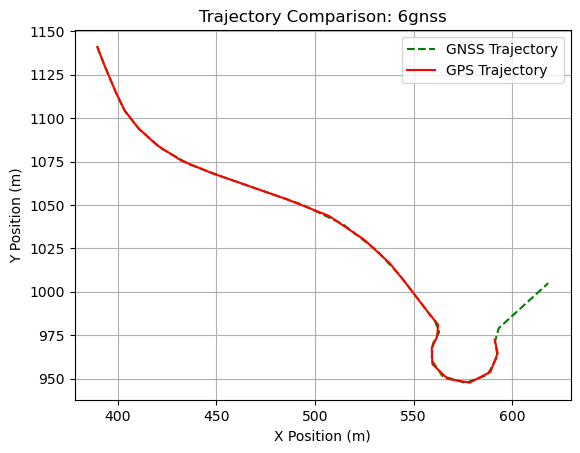

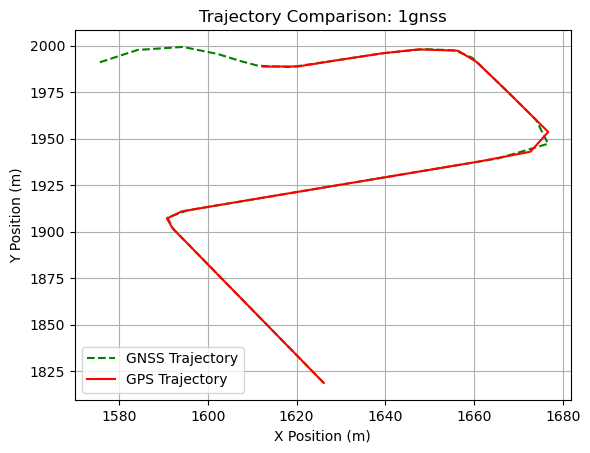

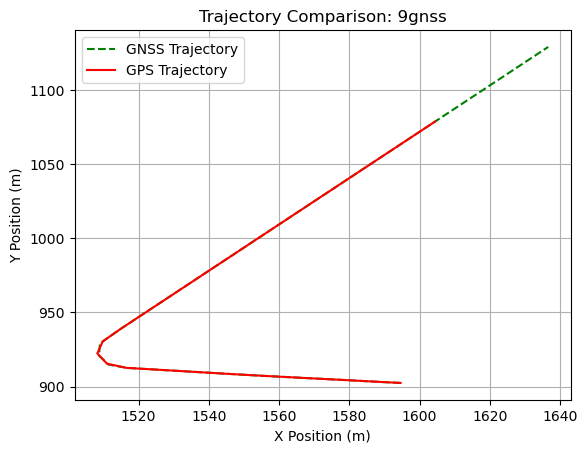

In [25]:
plot_trajectories(vehicle_positions, "6gnss", "6gps")
plot_trajectories(vehicle_positions, "1gnss", "1gps")

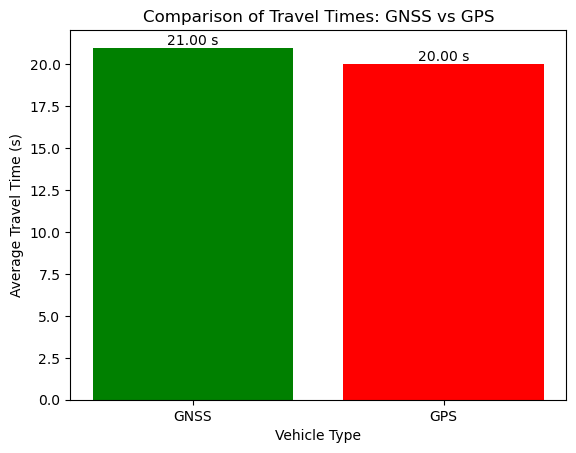

In [11]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

def parse_tripinfo(file_path):
    gnss_times = []
    gps_times = []

    tree = ET.parse(file_path)
    root = tree.getroot()

    for tripinfo in root.findall("tripinfo"):
        vehicle_id = tripinfo.get("id")
        travel_time = float(tripinfo.get("duration"))

        if "gnss" in vehicle_id:
            gnss_times.append(travel_time)
        elif "gps" in vehicle_id:
            gps_times.append(travel_time)

    return gnss_times, gps_times

def plot_travel_times(gnss_times, gps_times):
    labels = ["GNSS", "GPS"]
    avg_times = [sum(gnss_times) / len(gnss_times), sum(gps_times) / len(gps_times)]

    plt.bar(labels, avg_times, color=["green", "red"])
    
    # Annotate the bars with their values
    for i, avg_time in enumerate(avg_times):
        plt.text(i, avg_time + 0.2, f"{avg_time:.2f} s", ha="center", fontsize=10)

    plt.xlabel("Vehicle Type")
    plt.ylabel("Average Travel Time (s)")
    plt.title("Comparison of Travel Times: GNSS vs GPS")
    plt.show()

# File path to the tripinfo XML file
tripinfo_file = "tripinfo_output.xml"

# Parse and plot travel times
gnss_times, gps_times = parse_tripinfo(tripinfo_file)
plot_travel_times(gnss_times, gps_times)
